# simple 6D PS reconstruction

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.utils import split_2screen_dset
from phase_space_reconstruction.train import train_3d_scan_2screens

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from analysis_scripts import plot_3d_scan_data_2screens, plot_3d_scan_data_2screens_contour, create_clipped_dset

## Load data

In [2]:
# load data
dset = torch.load('clipped_dset.pt')

In [3]:
# max intensity
vmax1 = dset.images[4,0,0].max()
print(vmax1)
vmax2 = dset.images[4,0,1].max()
print(vmax2)

tensor(0.0021)
tensor(0.0010)


In [4]:
# split dset into train and test
train_dset, test_dset = split_2screen_dset(dset)

(<Figure size 1200x1000 with 30 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

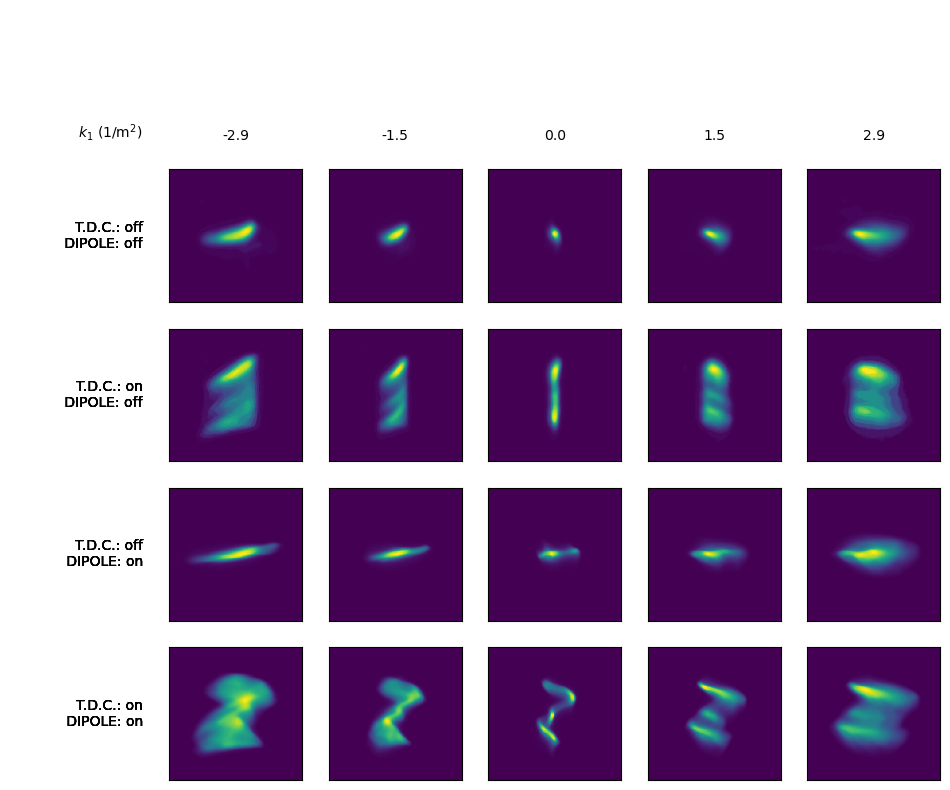

In [5]:
# plot train dset
plot_3d_scan_data_2screens(train_dset)

(<Figure size 1000x1000 with 25 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

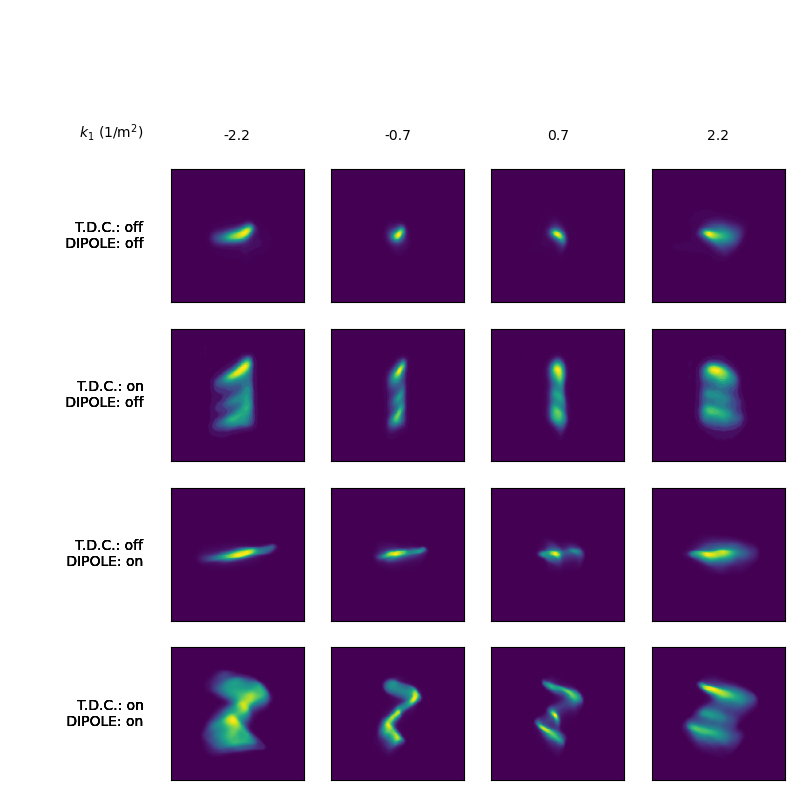

In [6]:
# plot test dset
plot_3d_scan_data_2screens(test_dset)

## Define diagnostics lattice parameters

In [7]:
# diagnostic beamline:
p0c = 43.3e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

width = dset.images.shape[-1]
screen0 = create_screen(30.22*1e-3*width/700, width)
screen1 = create_screen(26.96*1e-3*width/700, width)

### 10,000 particles

In [8]:
save_dir = '.'

In [9]:
%%time

# training
pred_beam = train_3d_scan_2screens(
    train_dset, 
    lattice0,
    lattice1, 
    p0c, 
    screen0,
    screen1,
    ids = scan_ids,
    n_epochs = 200, 
    n_particles = 50_000, 
    device = 'cuda',
    save_dir = save_dir,
    distribution_dump_frequency=200,
    distribution_dump_n_particles=1_000_000,
    )
torch.cuda.empty_cache()

Using device: cuda
0 tensor(2.1773e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
100 tensor(4.2434e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
200 tensor(3.7028e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
CPU times: user 1min 6s, sys: 19.4 s, total: 1min 25s
Wall time: 46.6 s


In [12]:
pred_beam = torch.load(os.path.join(save_dir, 'dist_200.pt'))

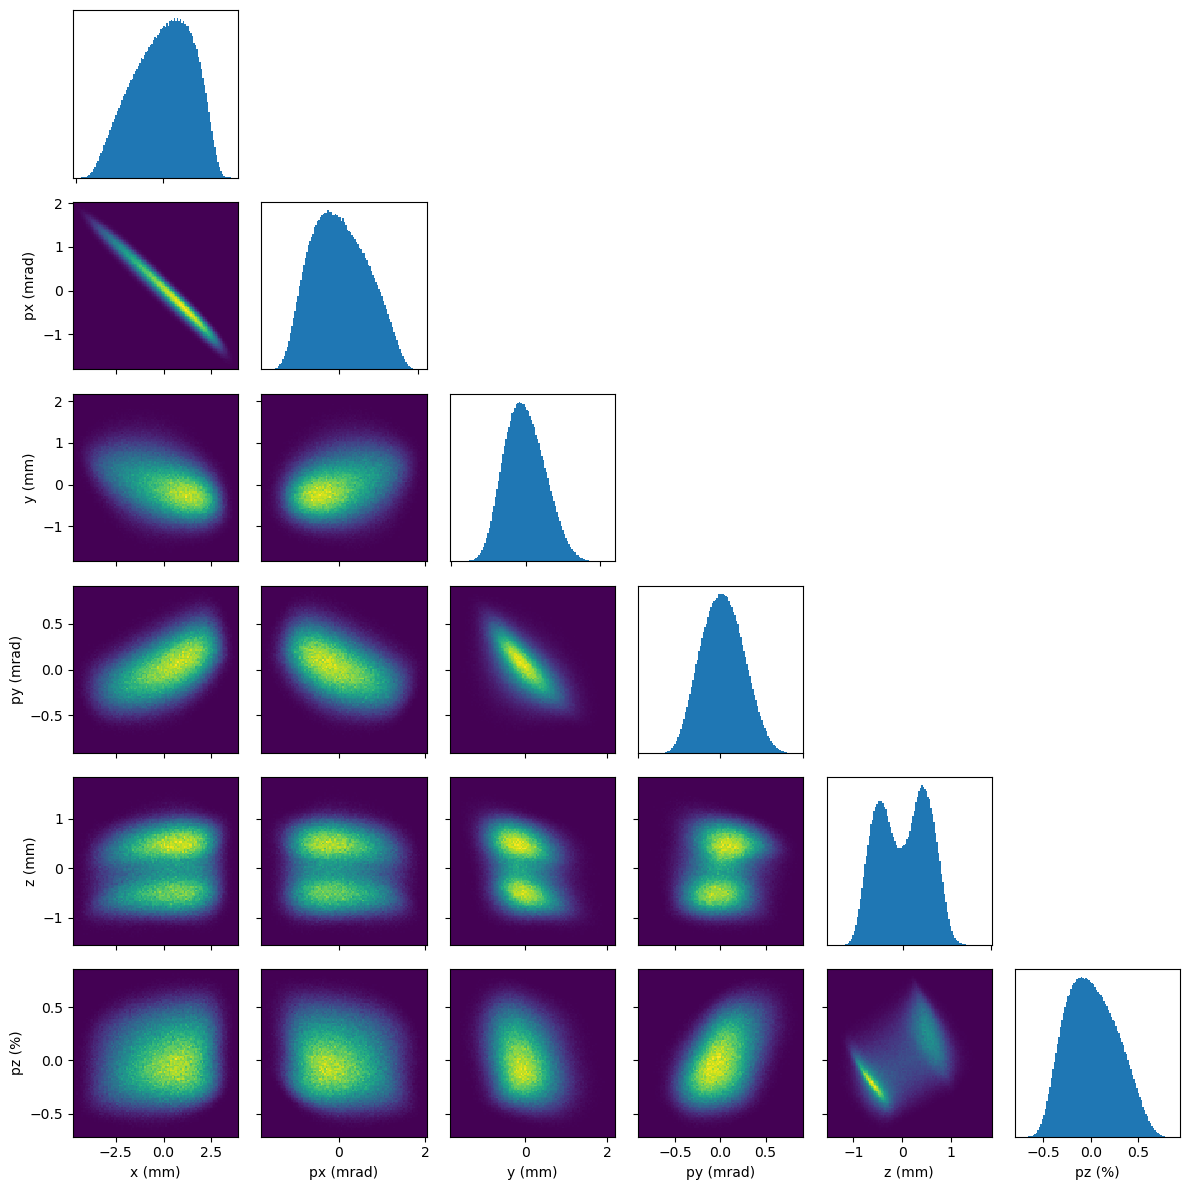

In [13]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam,
                           #custom_lims = lims,
                           bins = 100
                           )
plt.show()